In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sfm.plotstyle import set_seaborn_style, set_style_after

import os

In [58]:
# list all runs in runs/
# Get current notebook path since __file__ isn't defined in notebooks
currentfile = os.path.abspath('')
currentdir = os.path.dirname(currentfile)
runs = os.listdir(f"{currentdir}/runs")
print(runs)

# filter for target distributions
targetdist = "moons"
runs = [run for run in runs if f"-{targetdist}" in run]

# order alphabetically
runs = sorted(runs)
print(runs)


['beta-moons', 'beta-moons-ot', 'gaussian-moons', 'dirichlet-moons-ot', 'gamma-moons', 'mog-moons', 'diagonal-moons-ot', 'multivariate-moons', 'normal-moons-ot', 'diagonal-moons', 'multivariate-moons-ot', 'dirichlet-moons', '8gaussians-moons', 'uniform-moons-ot', 'gaussian-moons-ot', 'laplace-moons-ot', 'laplace-moons', '8gaussians-moons-ot', 'uniform-moons', 'gamma-moons-ot', 'normal-moons', 'mog-moons-ot']
['8gaussians-moons', '8gaussians-moons-ot', 'beta-moons', 'beta-moons-ot', 'diagonal-moons', 'diagonal-moons-ot', 'dirichlet-moons', 'dirichlet-moons-ot', 'gamma-moons', 'gamma-moons-ot', 'gaussian-moons', 'gaussian-moons-ot', 'laplace-moons', 'laplace-moons-ot', 'mog-moons', 'mog-moons-ot', 'multivariate-moons', 'multivariate-moons-ot', 'normal-moons', 'normal-moons-ot', 'uniform-moons', 'uniform-moons-ot']


In [59]:
# list files in first run
files = os.listdir(f"{currentdir}/runs/{runs[0]}")
print(files)


['train', 'targetdist.png', 'sidebyside', 'traj_8gaussians-to-moons.gif', 'losses.npy', 'mysimplemlp_10000.pth', 'logprob_8gaussians-to-moons_sidebyside.png', 'srctrgt.png', 'trajectory', 'logprobs_train.npy']


In [60]:
exclude = ["dirichlet", "beta", "gamma", "multivariate"]
filtered_runs = [run for run in runs if not any(e in run for e in exclude)]


8gaussians


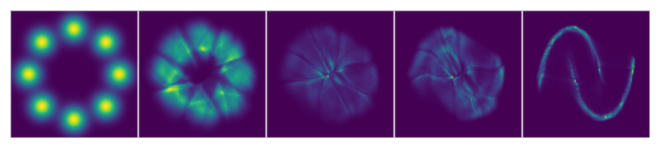

8gaussians OT


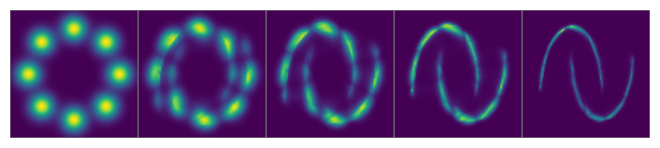

diagonal


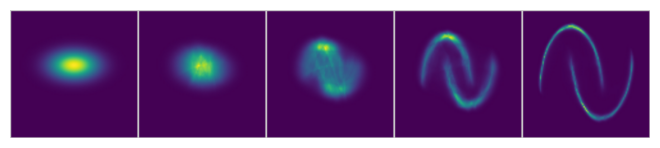

diagonal OT


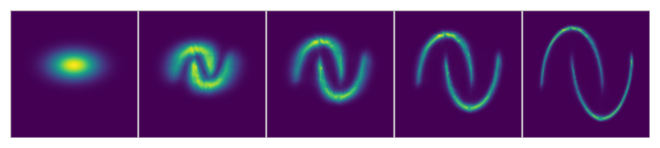

gaussian


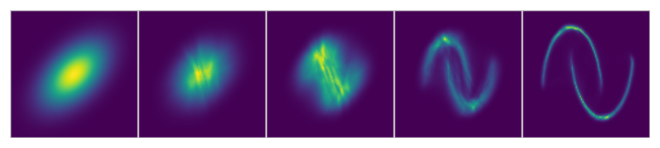

gaussian OT


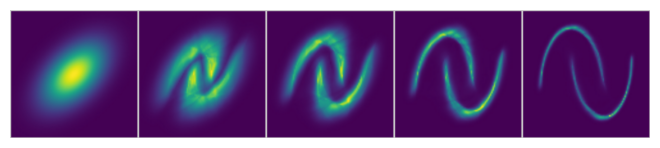

laplace


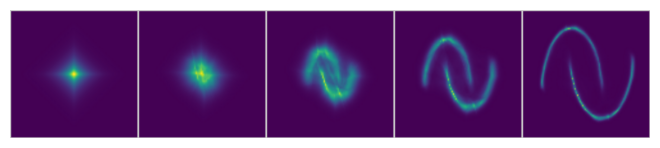

laplace OT


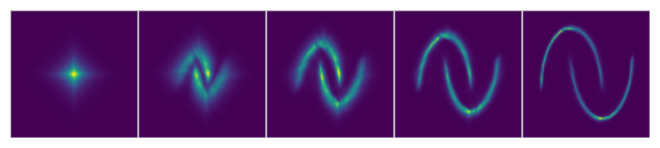

mog


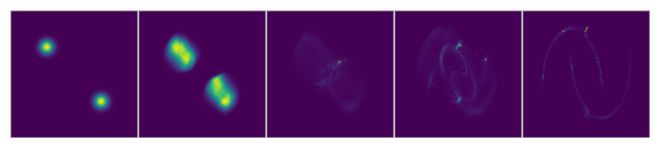

mog OT


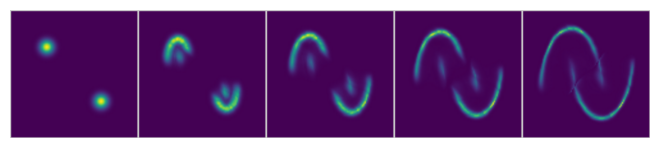

normal


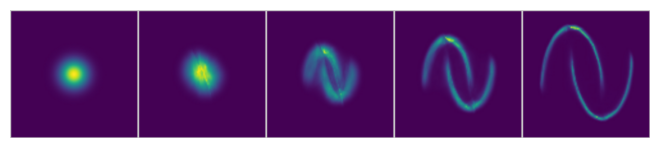

normal OT


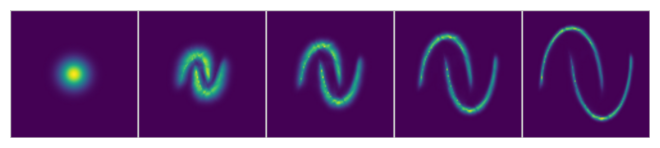

uniform


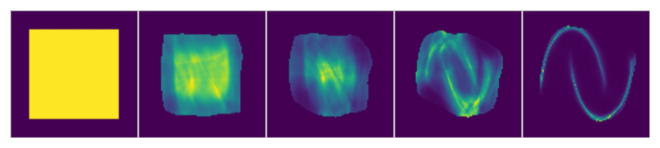

uniform OT


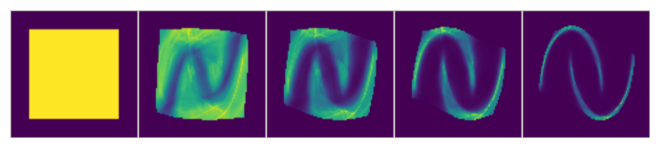

In [61]:
# for every run, show logprob_<src>-to-<trgt>_sidebyside.png
for run in filtered_runs:
    src = run.split("-")[0]
    trgt = run.split("-")[1]  
    runname = src
    if "-ot" in run:
        runname += " OT"
    print(runname)
    plt.imshow(plt.imread(f"{currentdir}/runs/{run}/logprob_{src}-to-{trgt}_sidebyside.png"))
    # remove axes
    plt.axis('off')
    # remove ticks
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    plt.tight_layout(pad=0)
    plt.show()


In [62]:
# only ot runs
runsfiltered = [run for run in runs if "-ot" in run]

# exclude dirichlet, beta
exclude = ["dirichlet", "beta", "gamma"]
runsfiltered = [run for run in runsfiltered if not any(e in run for e in exclude)]

print(runsfiltered)


['8gaussians-moons-ot', 'diagonal-moons-ot', 'gaussian-moons-ot', 'laplace-moons-ot', 'mog-moons-ot', 'multivariate-moons-ot', 'normal-moons-ot', 'uniform-moons-ot']


In [63]:
# get logprobs_train.npy and losses.npy for every run into a dict
logprobs_train = {}
losses = {}
for run in runsfiltered:
    logprobs_train[run] = np.load(f"{currentdir}/runs/{run}/logprobs_train.npy")
    losses[run] = np.load(f"{currentdir}/runs/{run}/losses.npy")


In [64]:
def get_human_name(_run):
    _run = _run.replace(f"-{targetdist}", "")
    ot = True if "-ot" in _run else False
    _run = _run.replace("-ot", "")
    _namesdict = {
        "dirichlet": "Dirichlet",
        "beta": "Beta",
        "gamma": "Gamma",
        "mog": "2Gaussians",
        "multivariate": "Multivariate",
        "8gaussians": "8Gaussians",
        "diagonal": "DiagGaussian",
        "laplace": "Laplace",
        "uniform": "Uniform",
        "gaussian": "Gaussian",
        "normal": "Normal",
    }
    return f"{_namesdict[_run]}{' OT' if ot else ''}"


In [65]:
# every model its own color
colors = sns.color_palette("deep", len(runsfiltered))
_cmap = {run: colors[i] for i, run in enumerate(runsfiltered)}

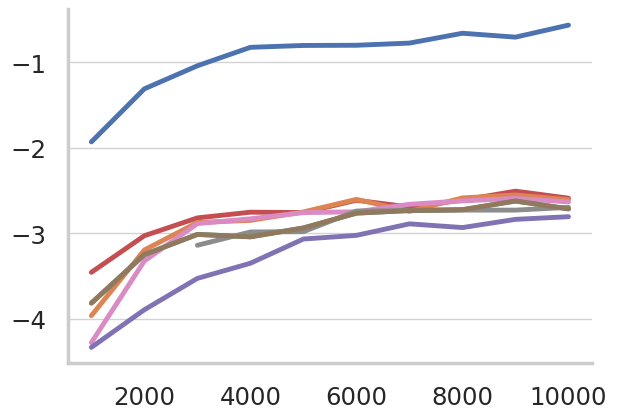

In [76]:
# plot logprobs_train.npy for every run
set_seaborn_style()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.set_yscale("symlog")
# the higher the logprob the better
_runsfiltered = sorted(runsfiltered, key=lambda x: -logprobs_train[x][-1, 1])
for run in _runsfiltered:
    # first column is x, second column is y
    ax.plot(
        logprobs_train[run][1:, 0], logprobs_train[run][1:, 1], 
        label=get_human_name(run),
        color=_cmap[run]
    )
# y log scale
set_style_after(ax, legend=False, loc="upper right", bbox_to_anchor=(1.0, .93), fs=10)
plt.show()
plt.close()

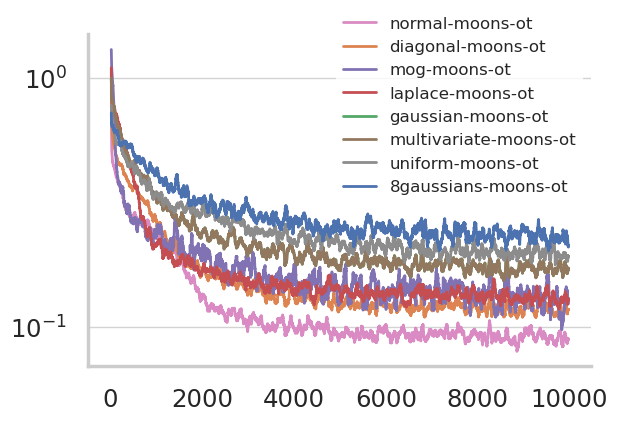

In [67]:
# plot losses.npy for every run
# apply smoothing to losses.npy
losses_smooth = {}
# first column is x=step, second column is y=loss
window_size = 51  # Use odd number to ensure equal padding on both sides
for run in runsfiltered:
    # Apply smoothing separately to x and y columns
    x = losses[run][:, 0]  # time steps
    y = losses[run][:, 1]  # loss values
    # Smooth only the y values
    y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
    # Trim x and y_smooth to same length
    trim = (window_size - 1) // 2
    x = x[trim:-trim]
    # Verify lengths match
    assert len(x) == len(y_smooth), f"Length mismatch: x={len(x)}, y_smooth={len(y_smooth)}"
    # Recombine into array
    losses_smooth[run] = np.column_stack((x, y_smooth))

# subsample, only plot every n'th point
n = 1
losses_smooth = {run: losses_smooth[run][::n, :] for run in runsfiltered}

set_seaborn_style()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_yscale("log")
# sort runsfiltered by lowest final loss
_runsfiltered = sorted(runsfiltered, key=lambda x: losses_smooth[x][-1, 1])
for run in _runsfiltered:
    ax.plot(
        losses_smooth[run][:, 0], losses_smooth[run][:, 1], label=run, linewidth=2,
        color=_cmap[run]
    )
set_style_after(ax, legend=True, loc="upper right", bbox_to_anchor=(1.0, 1.1), fs=12)
plt.show()
plt.close()

{'8gaussians-moons-ot': 0.20906924076524436, 'diagonal-moons-ot': 0.11684693498354333, 'gaussian-moons-ot': 0.1708737921481039, 'laplace-moons-ot': 0.12974771857261658, 'mog-moons-ot': 0.12371662156838997, 'multivariate-moons-ot': 0.1708737921481039, 'normal-moons-ot': 0.08914581700867298, 'uniform-moons-ot': 0.19243787331324}
{'8gaussians-moons-ot': -0.5668363571166992, 'diagonal-moons-ot': -2.6071255207061768, 'gaussian-moons-ot': -2.7146642208099365, 'laplace-moons-ot': -2.589277744293213, 'mog-moons-ot': -2.8057005405426025, 'multivariate-moons-ot': -2.7146642208099365, 'normal-moons-ot': -2.633063554763794, 'uniform-moons-ot': -2.696904420852661}
[[1.         0.54171101]
 [0.54171101 1.        ]]


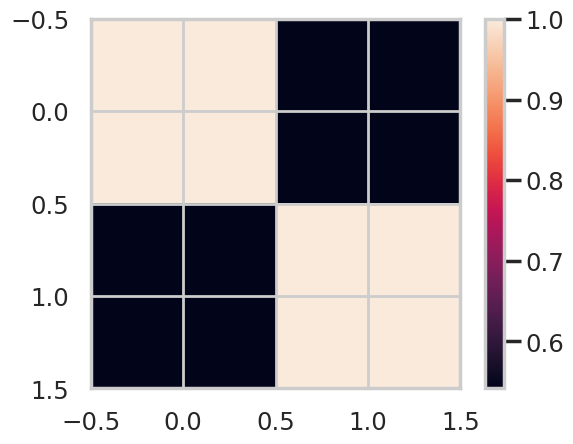

In [68]:
# plot correlation between lowest loss and highest (least negative) logprob_train
lowest_loss = {run: losses_smooth[run][-1, 1] for run in runsfiltered}
highest_logprob = {run: logprobs_train[run][-1, 1] for run in runsfiltered}

print(lowest_loss)
print(highest_logprob)

# plot correlation as heatmap
corr = np.corrcoef(list(lowest_loss.values()), list(highest_logprob.values()))
print(corr)
plt.imshow(corr)
plt.colorbar()
plt.show()
plt.close()


8gaussians-moons 1.0


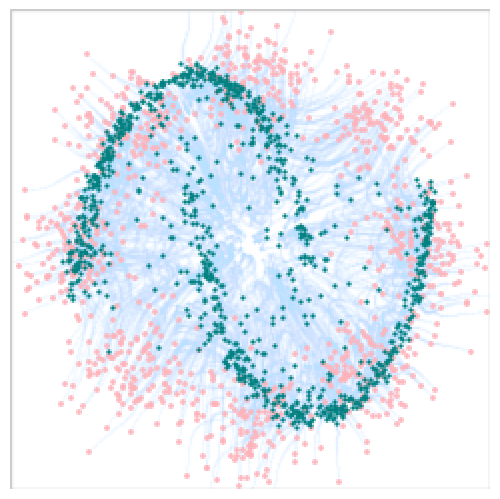

8gaussians-moons-ot 1.0


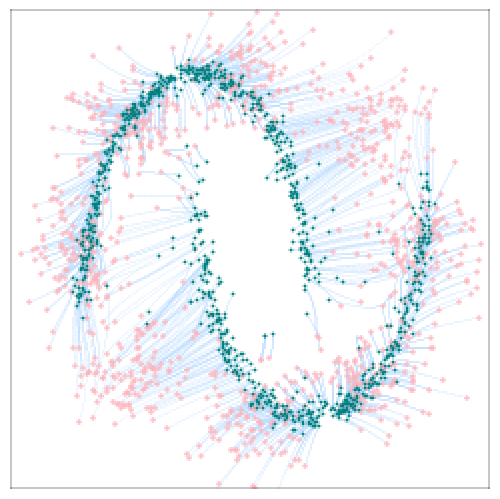

beta-moons 1.0


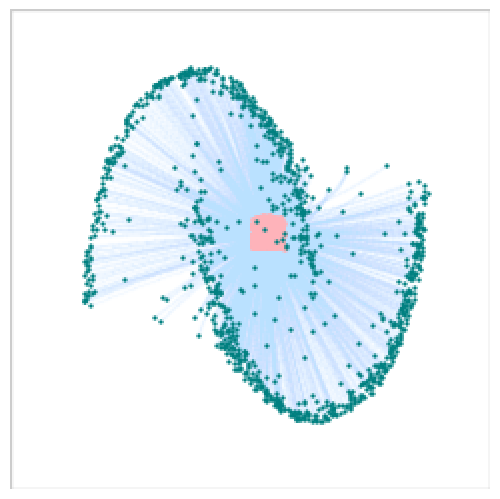

beta-moons-ot 1.0


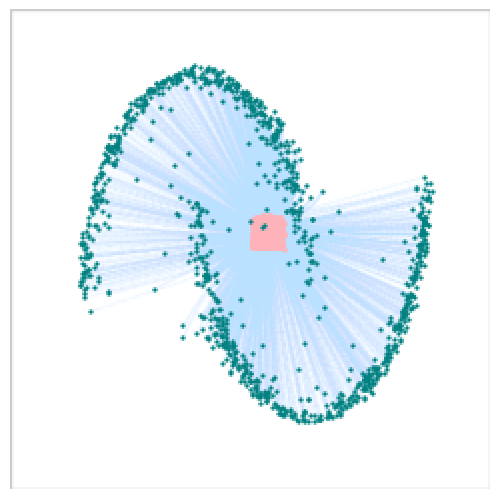

diagonal-moons 1.0


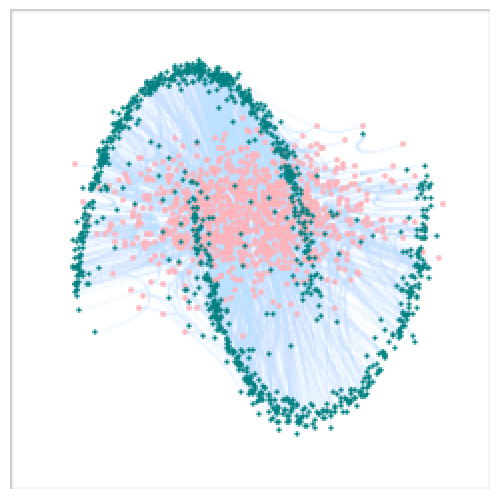

diagonal-moons-ot 1.0


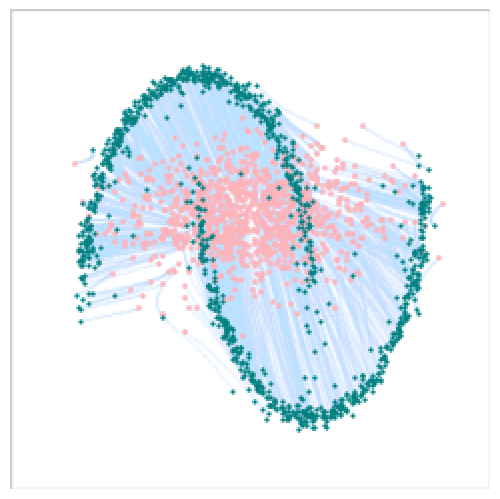

dirichlet-moons 1.0


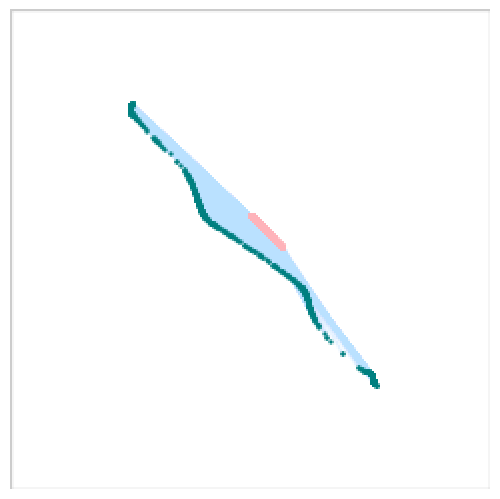

dirichlet-moons-ot 1.0


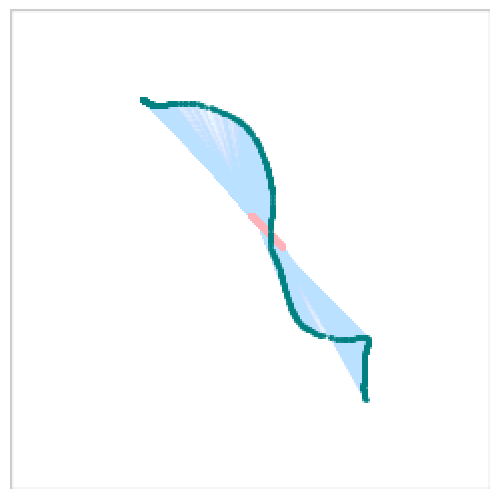

gamma-moons 1.0


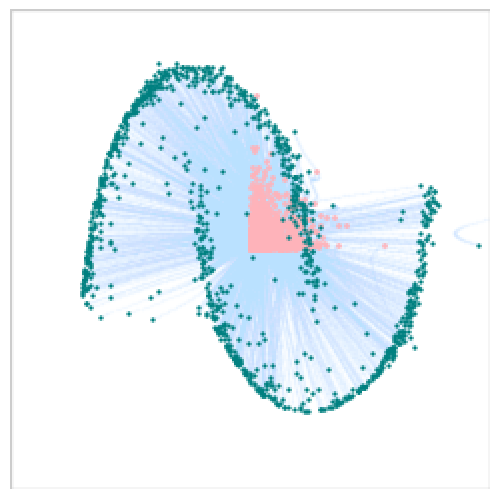

gamma-moons-ot 1.0


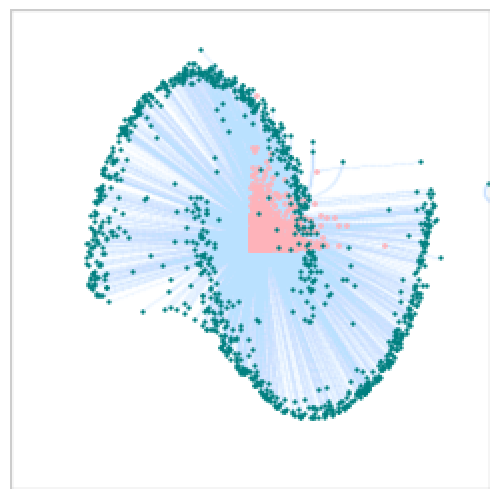

gaussian-moons 1.0


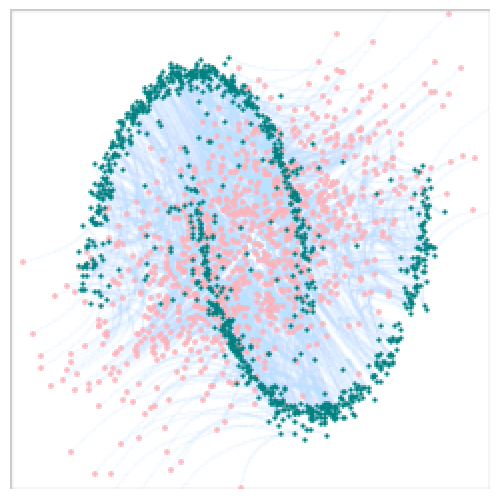

gaussian-moons-ot 1.0


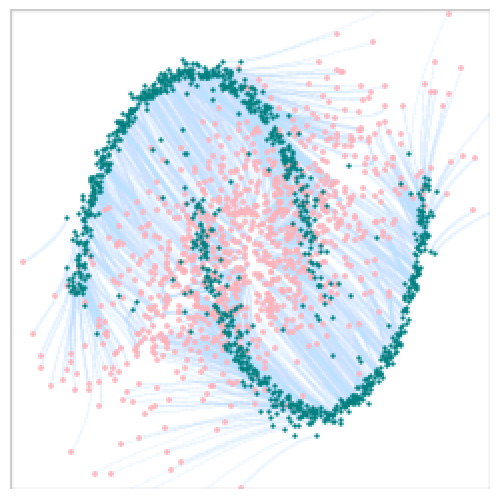

laplace-moons 1.0


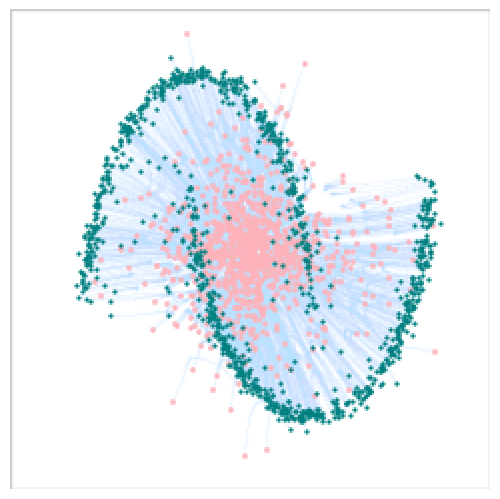

laplace-moons-ot 1.0


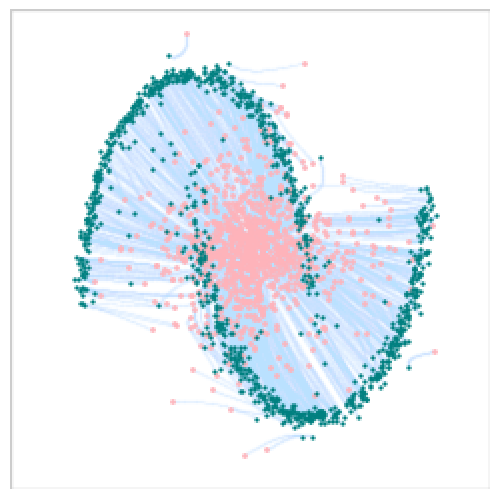

mog-moons 1.0


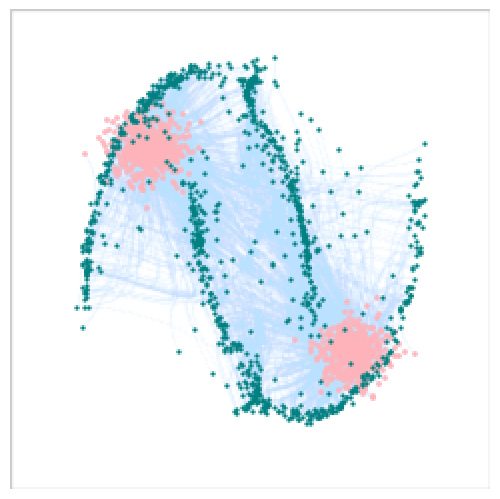

mog-moons-ot 1.0


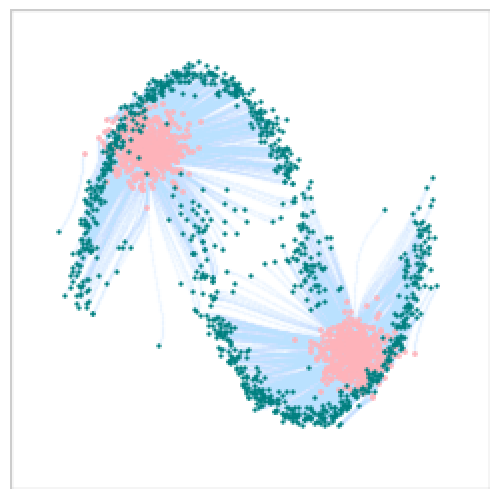

multivariate-moons 1.0


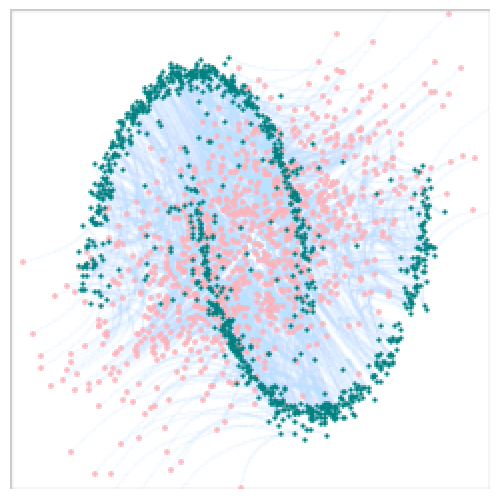

multivariate-moons-ot 1.0


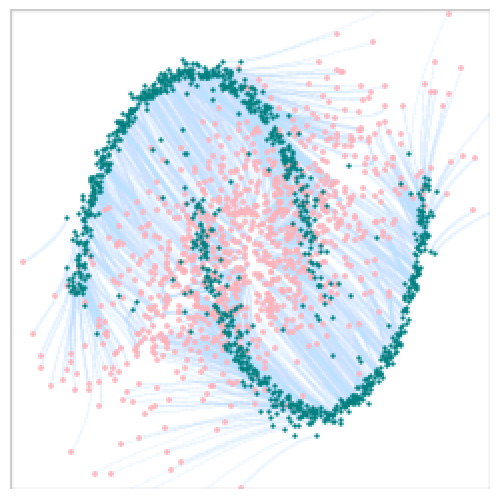

normal-moons 1.0


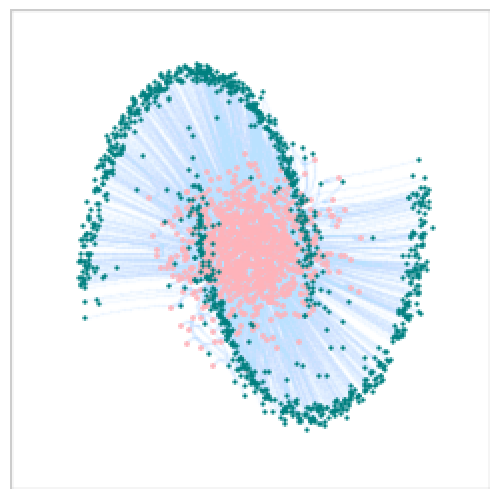

normal-moons-ot 1.0


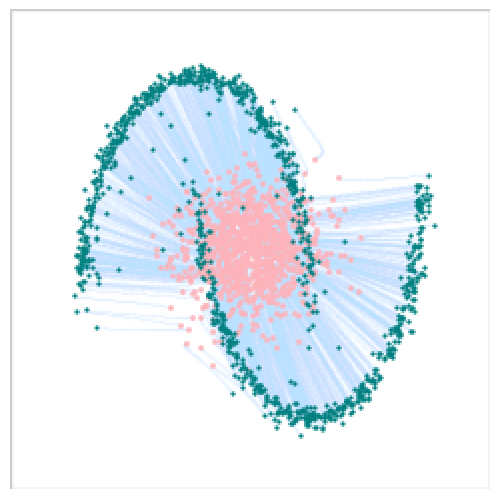

uniform-moons 1.0


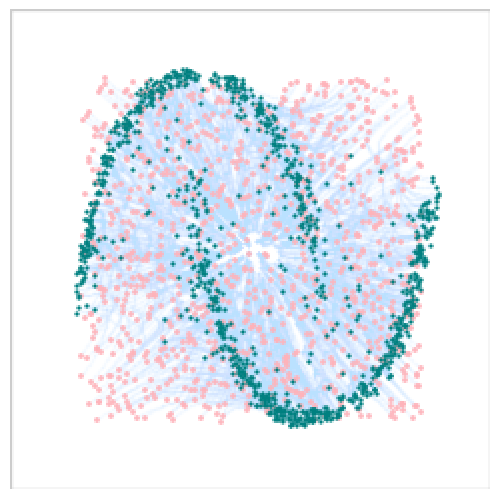

uniform-moons-ot 1.0


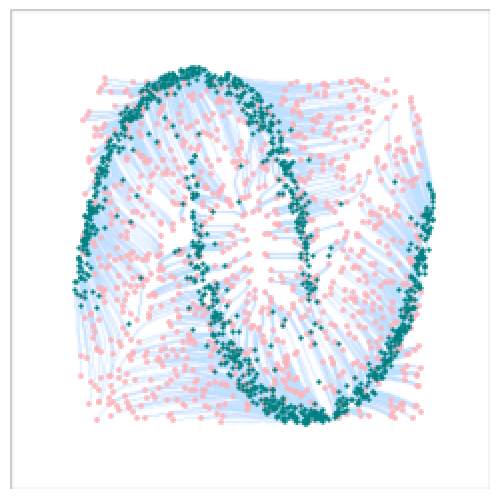

In [69]:
# plot the latest file in runs/<run>/trajectory/

for run in runs:
    _files = os.listdir(f"{currentdir}/runs/{run}/trajectory/")
    # time is in format _0.92.png
    _times = [float(file.split("_")[-1].split(".")[0]) for file in _files]
    latest_file = _files[_times.index(max(_times))]
    print(run, max(_times))
    
    plt.imshow(plt.imread(f"{currentdir}/runs/{run}/trajectory/{latest_file}"))
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    plt.close()